In [2]:
import sys
!{sys.executable} -m pip install tabulate

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from pprint import pprint
from tabulate import tabulate
from datetime import datetime, timedelta

## Preliminary Analysis


To get familiar with the dataset and remove the outliers.

• What is the distribution of trip distance of different types of roads? Plot ecdf and make comments.



   Unnamed: 0  vehicle_id  trip_id           start_time            stop_time  \
0           0           1        0  2023-09-29 13:55:35  2023-09-29 14:11:42   
1           1           1        0  2023-09-29 13:55:35  2023-09-29 14:11:42   
2           2           1        1  2023-09-29 14:32:24  2023-09-29 14:34:31   
3           3           1        2  2023-09-29 15:12:03  2023-09-29 15:26:55   
4           4           1        2  2023-09-29 15:12:03  2023-09-29 15:26:55   

  road  total_distance  
0    E           14.31  
1    U            1.47  
2    U            0.03  
3    E            2.60  
4    U            2.00  


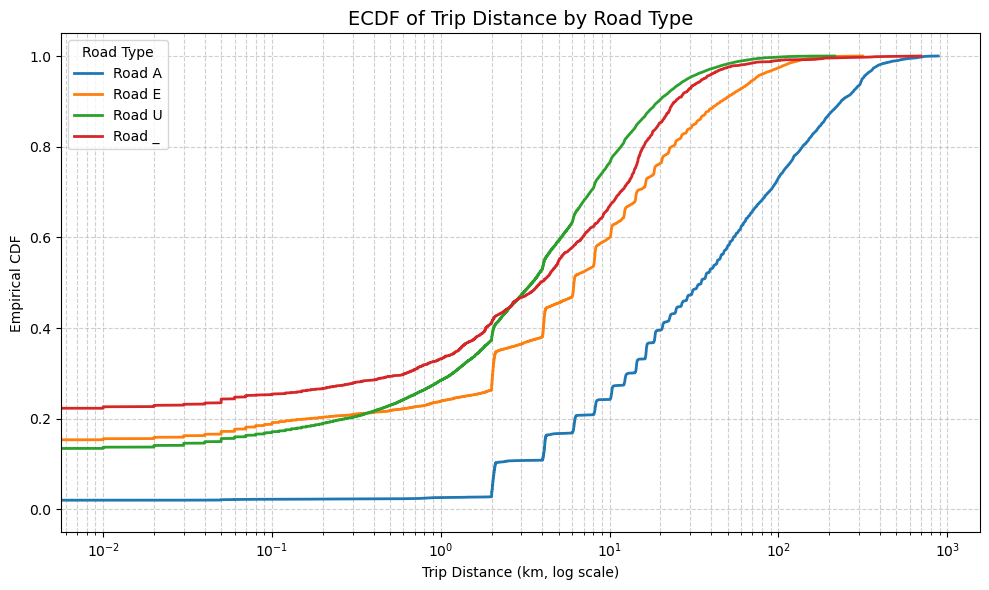

' Observations:\nUrban Roads (U): These trips typically have shorter distances, as seen by the steep rise in the ECDF at smaller distances.\nExtra-Urban (E): The distances are more spread out, with a smoother, less steep ECDF curve, indicating longer trip distances on average.\n'

In [4]:
# Load the uploaded CSV file to explore its contents
file_path = r'./Lab3/Unipol_dataset_lab3.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Extract relevant columns for analysis
road_types = data['road']
distances = data['total_distance']

# Check for missing or invalid values in relevant columns
data_cleaned = data.dropna(subset=['road', 'total_distance'])

# Group by road type and calculate ECDF for each group
road_groups = data_cleaned.groupby('road')

# Function to compute ECDF
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

# Plot ECDF for each road type
plt.figure(figsize=(10, 6))

for road, group in road_groups:
    x, y = ecdf(group['total_distance'])
    plt.plot(
        x, y,
        linewidth=2,
        label=f'Road {road}'
    )

# Slight plot improvements (minimal changes)
plt.xscale('log')
plt.title('ECDF of Trip Distance by Road Type', fontsize=14)
plt.xlabel('Trip Distance (km, log scale)')
plt.ylabel('Empirical CDF')
plt.legend(title='Road Type')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()


''' Observations:
Urban Roads (U): These trips typically have shorter distances, as seen by the steep rise in the ECDF at smaller distances.
Extra-Urban (E): The distances are more spread out, with a smoother, less steep ECDF curve, indicating longer trip distances on average.
'''

• What is the distribution of trip duration? Plot ecdf and make comments.



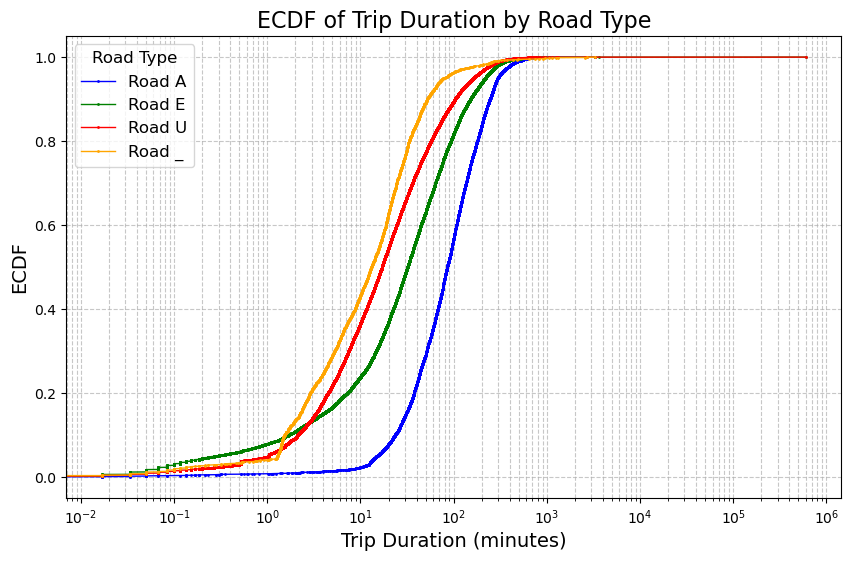

In [5]:
# Convert start_time and stop_time to datetime
data_cleaned['start_time'] = pd.to_datetime(data_cleaned['start_time'])
data_cleaned['stop_time'] = pd.to_datetime(data_cleaned['stop_time'])

# Calculate trip duration in minutes
data_cleaned['trip_duration'] = (data_cleaned['stop_time'] - data_cleaned['start_time']).dt.total_seconds() / 60

# Group by road type and calculate ECDF for trip duration
road_groups_duration = data_cleaned.groupby('road')


# Plot ECDF for trip duration for each road type
plt.figure(figsize=(10, 6))  # leggermente più grande
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']  # palette di colori distinti
for i, (road, group) in enumerate(road_groups_duration):
    x, y = ecdf(group['trip_duration'])
    plt.semilogx(x, y, marker='o', linestyle='-', linewidth=1, markersize=1, 
                 color=colors[i % len(colors)], label=f'Road {road}')

# Customize the plot
plt.title('ECDF of Trip Duration by Road Type', fontsize=16)
plt.xlabel('Trip Duration (minutes)', fontsize=14)
plt.ylabel('ECDF', fontsize=14)
plt.legend(title='Road Type', fontsize=12, title_fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Display the plot
plt.show()



• What is the relationship between trip duration and distance? Can you spot any difference among
trips with different road types?


Correlation between trip duration and distance for each road type:
Road A: 0.74
Road E: 0.01
Road U: 0.01
Road _: 0.16


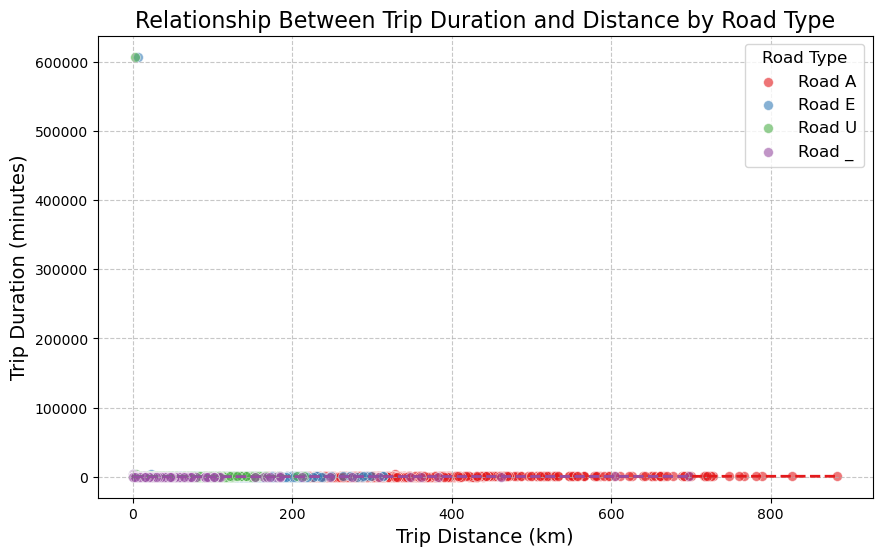

In [6]:
# Calculate correlation coefficients between trip duration and distance for each road type
road_correlation = {}
for road, group in road_groups:
    corr = group['trip_duration'].corr(group['total_distance'])
    road_correlation[road] = corr

# Display correlation coefficients
print("Correlation between trip duration and distance for each road type:")
for road, corr in road_correlation.items():
    print(f"Road {road}: {corr:.2f}")

# Scatter plot with regression lines for each road type
plt.figure(figsize=(10, 6))
palette = sns.color_palette('Set1', n_colors=len(road_groups))

for i, (road, group) in enumerate(road_groups):
    # Scatter points
    sns.scatterplot(
        x=group['total_distance'],
        y=group['trip_duration'],
        label=f'Road {road}',
        color=palette[i],
        s=50,  # marker size
        alpha=0.6
    )
    # Regression line
    sns.regplot(
        x=group['total_distance'],
        y=group['trip_duration'],
        scatter=False,
        color=palette[i],
        line_kws={"linestyle": "dashed", "linewidth": 2}
    )

# Customize the plot
plt.title('Relationship Between Trip Duration and Distance by Road Type', fontsize=16)
plt.xlabel('Trip Distance (km)', fontsize=14)
plt.ylabel('Trip Duration (minutes)', fontsize=14)
plt.legend(title='Road Type', fontsize=12, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()



• Filter the dataset, remove outliers (e.g. distance 0, impossible distance wrt duration) and report your
filter criteria. How many valid trips are recorded in the dataset?

In [7]:
# Define filtering criteria
min_distance = 0.1      # Minimum valid distance in km
max_distance = 1500     # Maximum valid distance in km
min_duration = 0.5      # Minimum valid trip duration in minutes
max_duration = 2500     # Maximum valid trip duration in minutes
min_speed = 1           # Minimum average speed in km/h
max_speed = 200         # Maximum reasonable average speed in km/h

# Filter dataset: Remove rows outside distance and duration thresholds
filtered_data = data_cleaned[
    (data_cleaned['total_distance'] > min_distance) &
    (data_cleaned['total_distance'] <= max_distance) &
    (data_cleaned['trip_duration'] > min_duration) &
    (data_cleaned['trip_duration'] <= max_duration)
].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Calculate average speed (km/h) and filter based on speed thresholds
filtered_data['average_speed'] = (
    filtered_data['total_distance'] / (filtered_data['trip_duration'] / 60)
)

filtered_data = filtered_data[
    (filtered_data['average_speed'] >= min_speed) &
    (filtered_data['average_speed'] <= max_speed)
]

# Count the number of valid trips
valid_trip_count = len(filtered_data)

# Display the filtering criteria and valid trip count
print("Filtering Criteria:")
print(f"1. Total distance > {min_distance} km and ≤ {max_distance} km")
print(f"2. Trip duration > {min_duration} minutes and ≤ {max_duration} minutes")
print(f"3. Average speed between {min_speed} km/h and {max_speed} km/h")
print(f"Number of valid trips: {valid_trip_count}")

# Output the first few rows of the filtered data for verification
print("\nSample of filtered data:")
print(filtered_data.head())

# Save filtered data to CSV
output_file = "./Lab3/filtered_trips.csv"
filtered_data.to_csv(output_file, index=False)
print(f"\nFiltered data saved to '{output_file}'.")


Filtering Criteria:
1. Total distance > 0.1 km and ≤ 1500 km
2. Trip duration > 0.5 minutes and ≤ 2500 minutes
3. Average speed between 1 km/h and 200 km/h
Number of valid trips: 57538

Sample of filtered data:
   Unnamed: 0  vehicle_id  trip_id          start_time           stop_time  \
0           0           1        0 2023-09-29 13:55:35 2023-09-29 14:11:42   
1           1           1        0 2023-09-29 13:55:35 2023-09-29 14:11:42   
3           3           1        2 2023-09-29 15:12:03 2023-09-29 15:26:55   
4           4           1        2 2023-09-29 15:12:03 2023-09-29 15:26:55   
5           5           1        3 2023-09-29 15:37:38 2023-09-29 15:57:26   

  road  total_distance  trip_duration  average_speed  
0    E           14.31      16.116667      53.274043  
1    U            1.47      16.116667       5.472596  
3    E            2.60      14.866667      10.493274  
4    U            2.00      14.866667       8.071749  
5    E            2.24      19.800000       6

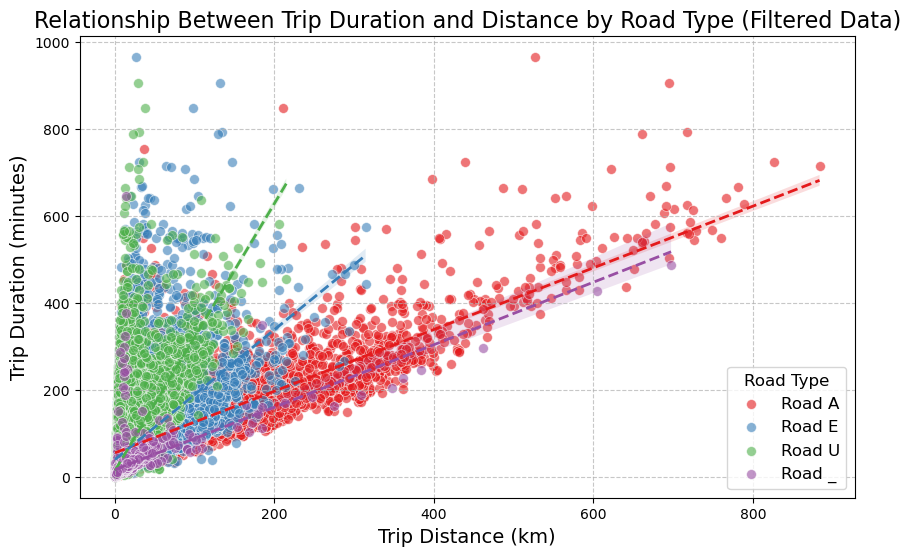

In [8]:
# Scatter plot with regression lines for each road type (filtered data)
plt.figure(figsize=(10, 6))
palette = sns.color_palette('Set1', n_colors=len(filtered_data['road'].unique()))

for i, (road, group) in enumerate(filtered_data.groupby('road')):
    # Scatter points
    sns.scatterplot(
        x=group['total_distance'],
        y=group['trip_duration'],
        label=f'Road {road}',
        color=palette[i],
        s=50,        # marker size
        alpha=0.6
    )
    # Regression line per road type
    sns.regplot(
        x=group['total_distance'],
        y=group['trip_duration'],
        scatter=False,
        color=palette[i],
        line_kws={"linestyle": "dashed", "linewidth": 2}
    )

# Customize the plot
plt.title('Relationship Between Trip Duration and Distance by Road Type (Filtered Data)', fontsize=16)
plt.xlabel('Trip Distance (km)', fontsize=14)
plt.ylabel('Trip Duration (minutes)', fontsize=14)
plt.legend(title='Road Type', fontsize=12, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()

## Tasks

**1.**  Analysing behaviours of vehicles. For each vehicle, aggregate the data on daily basis, compute following values:
- number of trips
- total distance
- utilization percetage

In [9]:
filtered_data

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance,trip_duration,average_speed
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.310,16.116667,53.274043
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.470,16.116667,5.472596
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.600,14.866667,10.493274
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.000,14.866667,8.071749
5,5,1,3,2023-09-29 15:37:38,2023-09-29 15:57:26,E,2.240,19.800000,6.787879
...,...,...,...,...,...,...,...,...,...
70120,70120,61,511,2023-11-04 10:29:13,2023-11-04 11:16:55,E,45.499,47.700000,57.231447
70121,70121,61,511,2023-11-04 10:29:13,2023-11-04 11:16:55,U,6.000,47.700000,7.547170
70122,70122,61,512,2023-11-04 11:21:07,2023-11-04 11:46:40,A,43.200,25.550000,101.448141
70123,70123,61,512,2023-11-04 11:21:07,2023-11-04 11:46:40,E,1.000,25.550000,2.348337


In [10]:
filtered_data['date'] = filtered_data['start_time'].dt.date
filtered_data['day_type'] = filtered_data['start_time'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

In [11]:
filtered_data

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance,trip_duration,average_speed,date,day_type
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.310,16.116667,53.274043,2023-09-29,Weekday
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.470,16.116667,5.472596,2023-09-29,Weekday
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.600,14.866667,10.493274,2023-09-29,Weekday
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.000,14.866667,8.071749,2023-09-29,Weekday
5,5,1,3,2023-09-29 15:37:38,2023-09-29 15:57:26,E,2.240,19.800000,6.787879,2023-09-29,Weekday
...,...,...,...,...,...,...,...,...,...,...,...
70120,70120,61,511,2023-11-04 10:29:13,2023-11-04 11:16:55,E,45.499,47.700000,57.231447,2023-11-04,Weekend
70121,70121,61,511,2023-11-04 10:29:13,2023-11-04 11:16:55,U,6.000,47.700000,7.547170,2023-11-04,Weekend
70122,70122,61,512,2023-11-04 11:21:07,2023-11-04 11:46:40,A,43.200,25.550000,101.448141,2023-11-04,Weekend
70123,70123,61,512,2023-11-04 11:21:07,2023-11-04 11:46:40,E,1.000,25.550000,2.348337,2023-11-04,Weekend


In [12]:
# aggregate data on daily basis for each vehicle and road type
daily_aggregation = filtered_data.groupby(['vehicle_id', 'date', 'road', 'day_type']).agg(
    total_distance=('total_distance', 'sum'),   # compute total distance by summing up distances
    total_trip_duration=('trip_duration', 'sum'),   # compute total trip duration by summing up durations
    num_trips=('trip_id', 'nunique')    # count unique trips id
).reset_index()

# evaluate daily utilization of each vehicle
daily_aggregation['daily_utilization'] = daily_aggregation.groupby(['vehicle_id', 'date'])['total_trip_duration'].transform('sum') / (24 * 60)  # 24 hours
# save as CSV
daily_aggregation.to_csv('./Lab3/daily_vehicle_aggregation.csv', index=False)
print("Daily aggregation saved to './Lab3/daily_vehicle_aggregation.csv'")

Daily aggregation saved to './Lab3/daily_vehicle_aggregation.csv'


In [13]:
daily_aggregation

,vehicle_id,date,road,day_type,total_distance,total_trip_duration,num_trips,daily_utilization
0,1,2023-09-29,E,Weekday,19.150,50.783333,3,0.070532
1,1,2023-09-29,U,Weekday,5.480,50.783333,3,0.070532
2,1,2023-09-30,E,Weekend,6.130,41.700000,3,0.073808
3,1,2023-09-30,U,Weekend,5.050,64.583333,5,0.073808
4,1,2023-10-01,A,Weekend,200.989,268.983333,1,0.373588
...,...,...,...,...,...,...,...,...
8782,61,2023-11-03,E,Weekday,178.094,451.583333,18,0.752153
8783,61,2023-11-03,U,Weekday,47.796,381.750000,12,0.752153
8784,61,2023-11-04,A,Weekend,381.698,369.183333,6,0.824375
8785,61,2023-11-04,E,Weekend,213.702,421.733333,9,0.824375


**1.a.** Compute the statistics and distribution of the values on workdays and weekends/holidays.
Can you find any difference? Can you find some vehicles behave consistently?

In [14]:
# extract the amount of total trips on each road type during weekdays and weekends
fraction_data = daily_aggregation.groupby(['day_type', 'road'], as_index=False).agg(
    num_trips=('num_trips', 'sum'),
    average_trip_duration=('total_trip_duration', 'mean'),
)

fraction_data['fraction'] = fraction_data['num_trips'] / fraction_data['num_trips'].sum()

In [15]:
fraction_data

,day_type,road,num_trips,average_trip_duration,fraction
0,Weekday,A,6004,368.829512,0.104348
1,Weekday,E,14754,431.349009,0.256422
2,Weekday,U,24643,440.586169,0.428291
3,Weekday,_,1235,341.236700,0.021464
4,Weekend,A,1265,299.150702,0.021985
5,Weekend,E,3064,321.910242,0.053252
6,Weekend,U,6212,359.090270,0.107963
7,Weekend,_,361,310.665686,0.006274


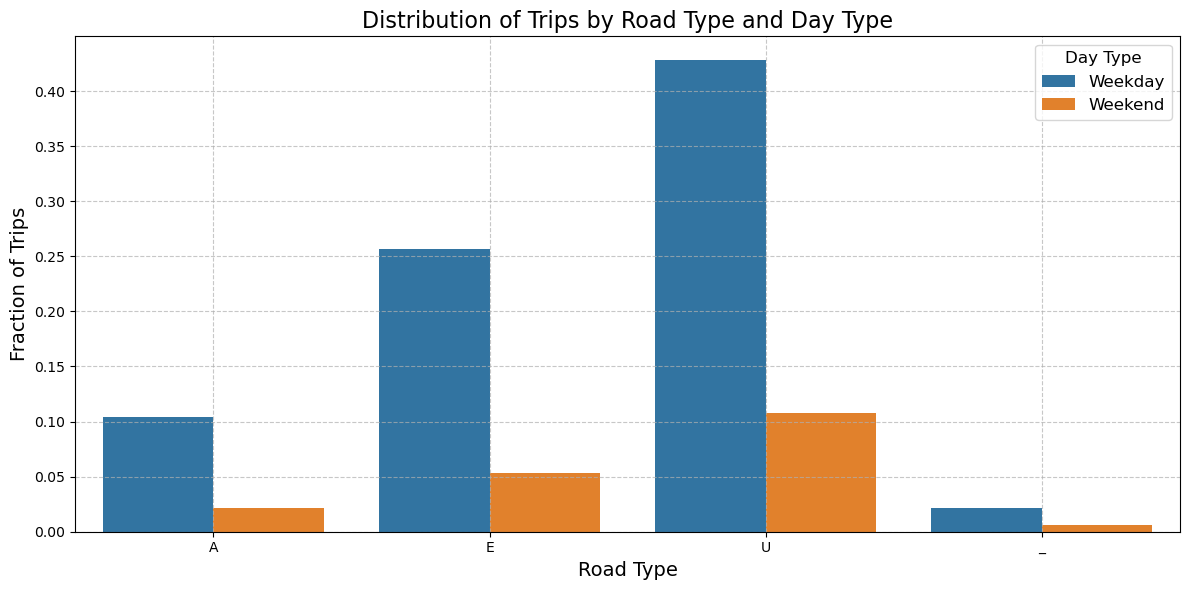

In [16]:
# compute the statistics and distribution of the values on workdays and weekends/holidays.

plt.figure(figsize=(12, 6))
sns.barplot(data=fraction_data, x='road', y='fraction', hue='day_type')
plt.title('Distribution of Trips by Road Type and Day Type', fontsize=16)
plt.xlabel('Road Type', fontsize=14)
plt.ylabel('Fraction of Trips', fontsize=14)
plt.legend(title='Day Type', fontsize=12, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

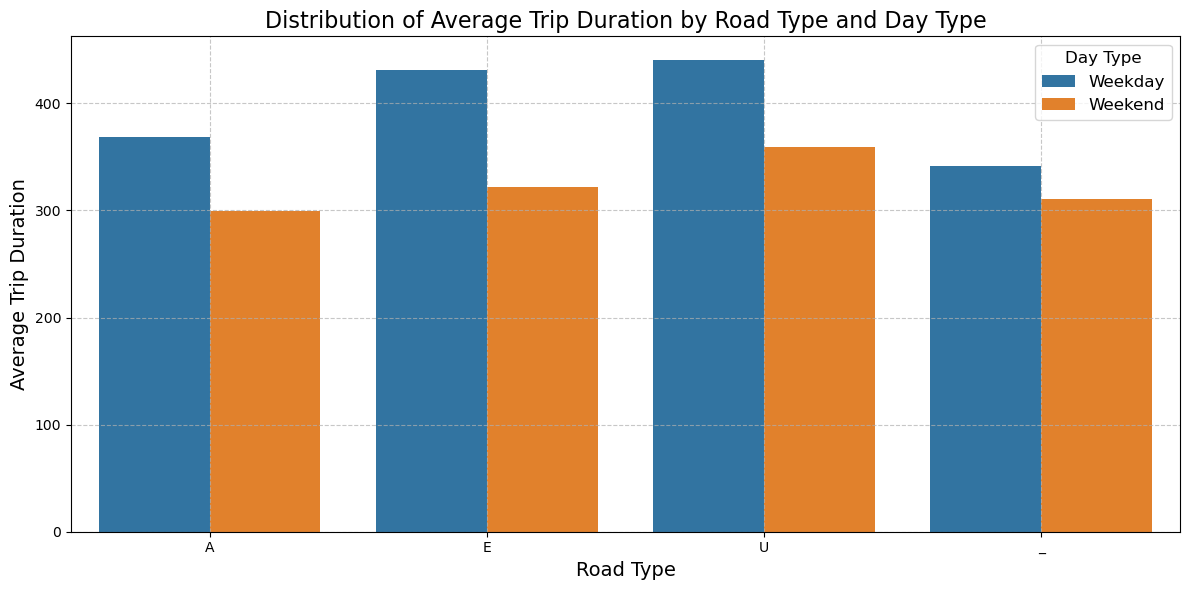

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(data=fraction_data, x='road', y='average_trip_duration', hue='day_type')
plt.title('Distribution of Average Trip Duration by Road Type and Day Type', fontsize=16)
plt.xlabel('Road Type', fontsize=14)
plt.ylabel('Average Trip Duration', fontsize=14)
plt.legend(title='Day Type', fontsize=12, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
daily_data = daily_aggregation.groupby(['vehicle_id', 'date', 'day_type']).agg(
    total_distance =('total_distance', 'sum'),
    total_trip_duration =('total_trip_duration', 'sum'),
    num_trips =('num_trips', 'sum')
).reset_index()

In [19]:
daily_data

,vehicle_id,date,day_type,total_distance,total_trip_duration,num_trips
0,1,2023-09-29,Weekday,24.630,101.566667,6
1,1,2023-09-30,Weekend,11.180,106.283333,8
2,1,2023-10-01,Weekend,361.539,537.966667,2
3,1,2023-10-02,Weekday,723.305,1334.816667,13
4,1,2023-10-03,Weekday,519.620,1111.033333,14
...,...,...,...,...,...,...
3303,61,2023-10-30,Weekday,659.994,1328.966667,27
3304,61,2023-10-31,Weekday,449.495,905.916667,21
3305,61,2023-11-02,Weekday,662.193,1396.050000,36
3306,61,2023-11-03,Weekday,481.490,1083.100000,35


In [20]:
statistics = daily_data.groupby('day_type').agg(
    avg_distance=('total_distance', 'mean'),
    std_distance=('total_distance', 'std'),
    min_distance=('total_distance', 'min'),
    max_distance=('total_distance', 'max'),
    avg_duration=('total_trip_duration', 'mean'),
    std_duration=('total_trip_duration', 'std'),
    min_duration=('total_trip_duration', 'min'),
    max_duration=('total_trip_duration', 'max'),
    avg_trips=('num_trips', 'mean'),
    std_trips=('num_trips', 'std'),
    min_trips=('num_trips', 'min'),
    max_trips=('num_trips', 'max')
).reset_index()

In [21]:
statistics

,day_type,avg_distance,std_distance,min_distance,max_distance,avg_duration,std_duration,min_duration,max_duration,avg_trips,std_trips,min_trips,max_trips
0,Weekday,424.830521,259.924285,0.17,1479.460,1126.459635,550.076790,0.733333,3981.800000,18.440490,10.363017,1,66
1,Weekend,288.167567,230.032929,0.12,1379.395,822.053701,580.707473,2.083333,2952.216667,13.994865,10.736023,1,56


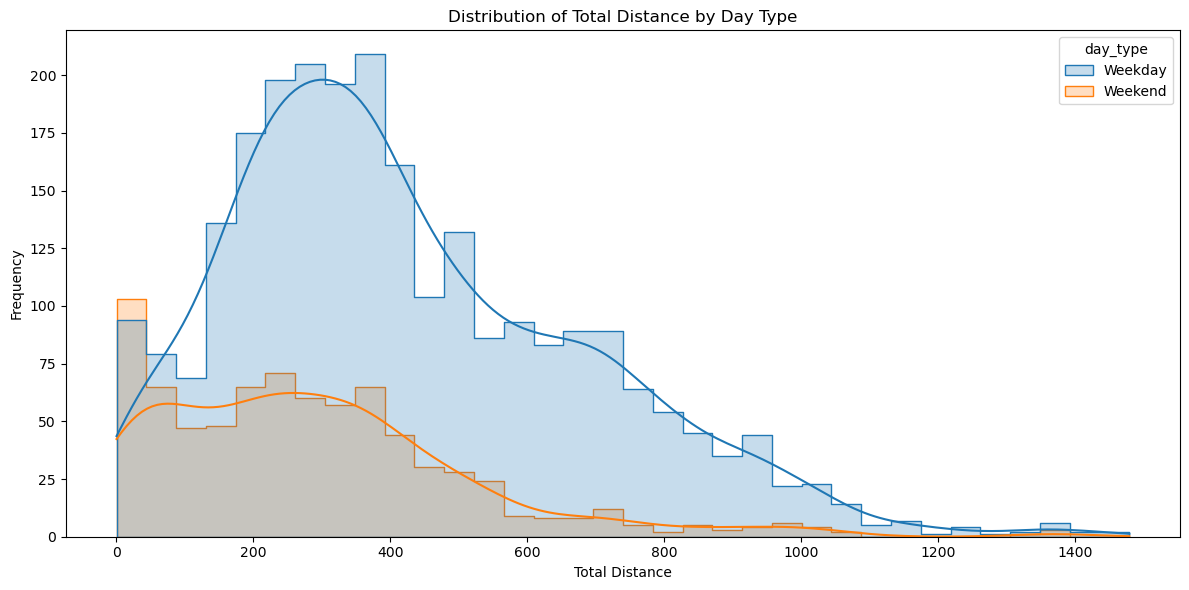

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='total_distance', hue='day_type', kde=True, element='step')
plt.title('Distribution of Total Distance by Day Type')
plt.xlabel('Total Distance')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

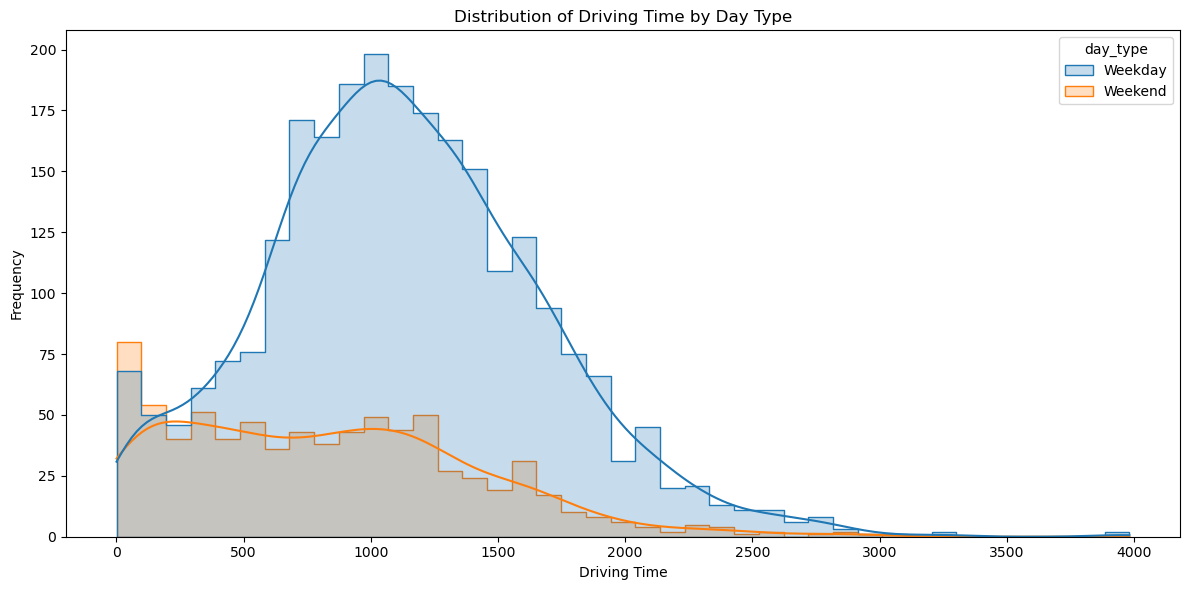

In [23]:
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='total_trip_duration', hue='day_type', kde=True, element='step')
plt.title('Distribution of Driving Time by Day Type')
plt.xlabel('Driving Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

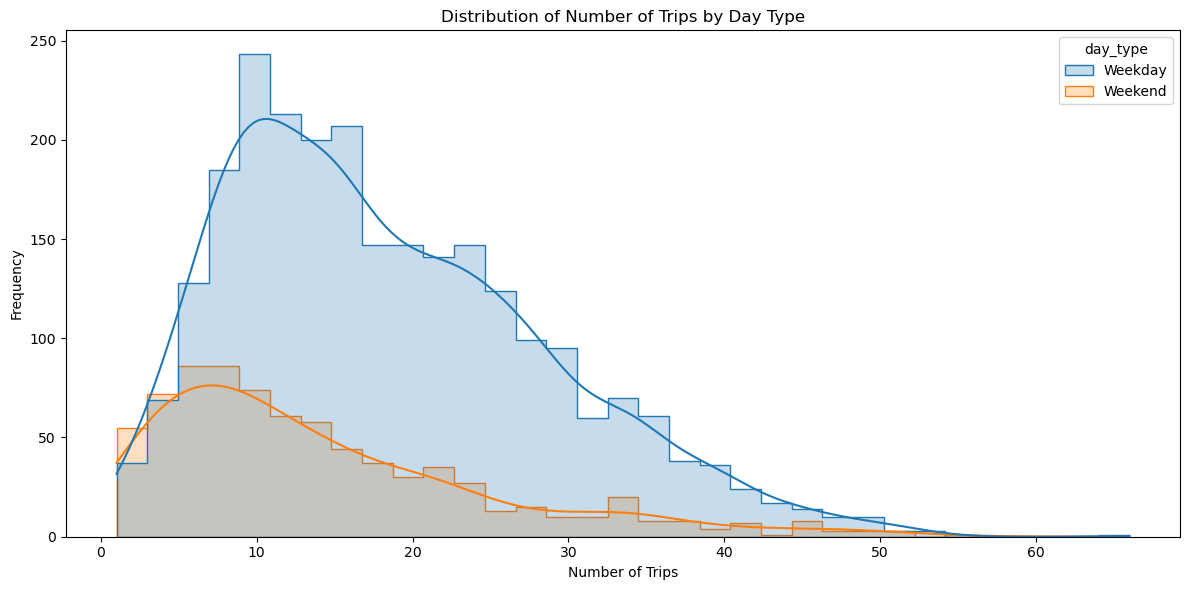

In [24]:
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='num_trips', hue='day_type', kde=True, element='step')
plt.title('Distribution of Number of Trips by Day Type')
plt.xlabel('Number of Trips')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**1.b.** For each vehicle, compute the fraction of its trips with different road types. Choose a
meaningful way to show the results and make comments.

In [25]:
# compute trip counts per vehicle and road type
trip_counts = daily_aggregation.groupby(['vehicle_id', 'road'])['num_trips'].sum().reset_index()

# compute total trips per vehicle
total_trips = daily_aggregation.groupby('vehicle_id')['num_trips'].sum().reset_index()
total_trips.rename(columns={'num_trips': 'total_trips'}, inplace=True)

# merge trip counts with total trips to compute fractions
vehicle_road_fraction = pd.merge(trip_counts, total_trips, on='vehicle_id')
vehicle_road_fraction['fraction'] = vehicle_road_fraction['num_trips'] / vehicle_road_fraction['total_trips']

In [26]:
vehicle_road_fraction

,vehicle_id,road,num_trips,total_trips,fraction
0,1,A,149,723,0.206086
1,1,E,351,723,0.485477
2,1,U,223,723,0.308437
3,2,A,142,496,0.286290
4,2,E,209,496,0.421371
...,...,...,...,...,...
185,59,U,993,1591,0.624136
186,60,_,1451,1451,1.000000
187,61,A,141,795,0.177358
188,61,E,378,795,0.475472


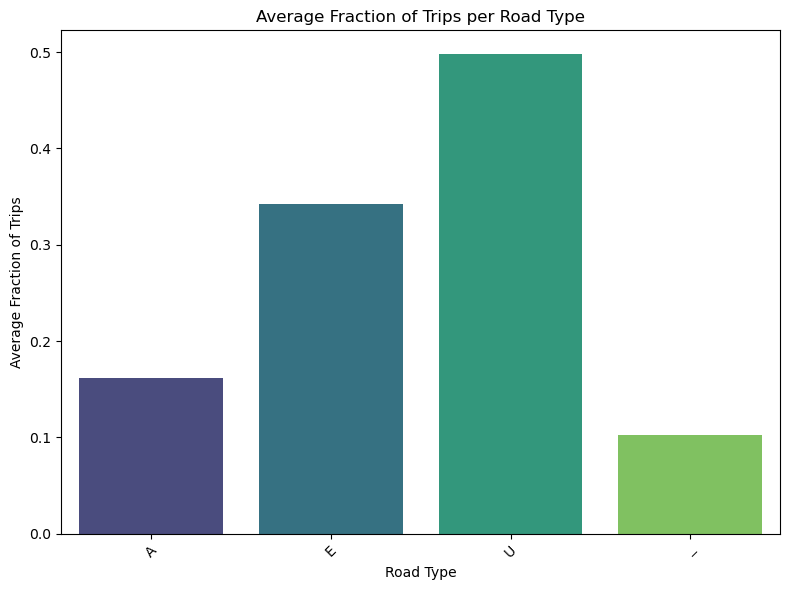

In [27]:
average_fraction = vehicle_road_fraction.groupby('road')['fraction'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=average_fraction, x='road', y='fraction', hue='road', palette='viridis')
plt.title('Average Fraction of Trips per Road Type')
plt.xlabel('Road Type')
plt.ylabel('Average Fraction of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

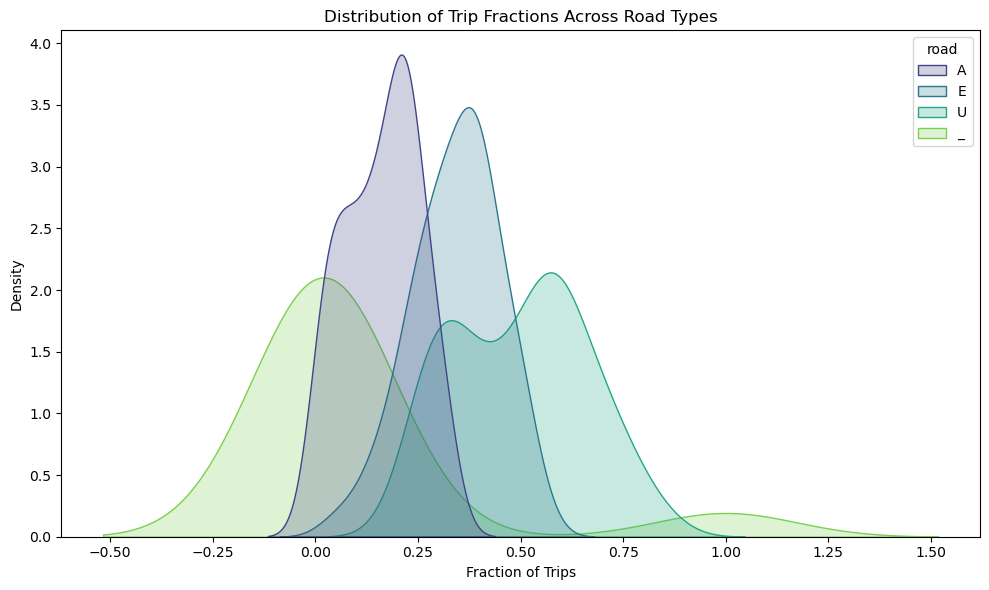

In [28]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=vehicle_road_fraction, x='fraction', hue='road', fill=True, common_norm=False, palette='viridis')
plt.title('Distribution of Trip Fractions Across Road Types')
plt.xlabel('Fraction of Trips')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

**1.c.** According to the characters you find, categorize and cluster the vehicles into 3-5 types based on their behaviours.

In [29]:
vehicle_road = daily_aggregation.groupby(['vehicle_id', 'road']).agg(
    total_distance=('total_distance', 'sum'),
    daily_utilization=('daily_utilization', 'mean')
).reset_index()

In [30]:
vehicle_road

,vehicle_id,road,total_distance,daily_utilization
0,1,A,16499.866,0.754742
1,1,E,8972.230,0.652501
2,1,U,975.180,0.696949
3,2,A,26399.630,1.115323
4,2,E,6710.260,1.060207
...,...,...,...,...
185,59,U,8733.660,0.834301
186,60,_,16792.620,0.361143
187,61,A,10005.068,0.865808
188,61,E,4588.739,0.808490


In [51]:
# Create separate DataFrames for distance and utilization, then merge
distance_pivot = vehicle_road.pivot(
    index='vehicle_id',
    columns='road',
    values='total_distance'
).add_prefix('total_distance_road_').fillna(0)

utilization_pivot = vehicle_road.pivot(
    index='vehicle_id',
    columns='road',
    values='daily_utilization'
).add_prefix('daily_utilization_road_').fillna(0)

# Merge the two pivoted DataFrames
vehicle_data = distance_pivot.join(utilization_pivot).reset_index()

In [54]:
vehicle_data

road,vehicle_id,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road__,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road__
0,1,16499.866,8972.230,975.180,0.00,0.754742,0.652501,0.696949,0.000000
1,2,26399.630,6710.260,1039.980,0.00,1.115323,1.060207,1.069699,0.000000
2,3,26903.090,7271.407,1399.777,0.00,1.163779,1.094111,1.093671,0.000000
3,4,133.670,6597.900,7846.860,0.00,0.613369,0.544172,0.506565,0.000000
4,5,24682.180,9247.150,1340.720,0.00,1.224829,1.083994,1.025529,0.000000
...,...,...,...,...,...,...,...,...,...
56,57,5618.110,8183.530,6711.880,0.00,0.839341,0.758790,0.698100,0.000000
57,58,9060.760,4286.970,3455.800,0.00,0.729847,0.673875,0.639581,0.000000
58,59,311.250,8658.370,8733.660,0.00,1.092477,0.834301,0.834301,0.000000
59,60,0.000,0.000,0.000,16792.62,0.000000,0.000000,0.000000,0.361143


In [33]:
# normalize the features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
road_features = [col for col in vehicle_data.columns if 'total_distance' in col]
utilization_feature = [col for col in vehicle_data.columns if 'daily_utilization' in col]
features = road_features + utilization_feature
selected_data = vehicle_data[features]
vehicle_data[features] = scaler.fit_transform(vehicle_data[features])

In [34]:
vehicle_data

road,vehicle_id,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road__,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road__
0,1,0.713250,0.794596,-0.995253,-0.180031,-0.247200,-0.564763,-0.267722,-0.464775
1,2,1.815271,0.181457,-0.978193,-0.180031,1.204827,1.497782,1.614320,-0.464775
2,3,1.871316,0.333563,-0.883468,-0.180031,1.399955,1.669297,1.735359,-0.464775
3,4,-1.108600,0.151000,0.813870,-0.180031,-0.816495,-1.112794,-1.228984,-0.464775
4,5,1.624088,0.869117,-0.899016,-0.180031,1.645799,1.618120,1.391302,-0.464775
...,...,...,...,...,...,...,...,...,...
56,57,-0.498084,0.580807,0.515062,-0.180031,0.093474,-0.027059,-0.261911,-0.464775
57,58,-0.114855,-0.475411,-0.342174,-0.180031,-0.347450,-0.456638,-0.557378,-0.464775
58,59,-1.088832,0.709520,1.047340,-0.180031,1.112828,0.354944,0.425779,-0.464775
59,60,-1.123480,-1.637455,-1.251991,7.298926,-3.286479,-3.865707,-3.786669,0.447869


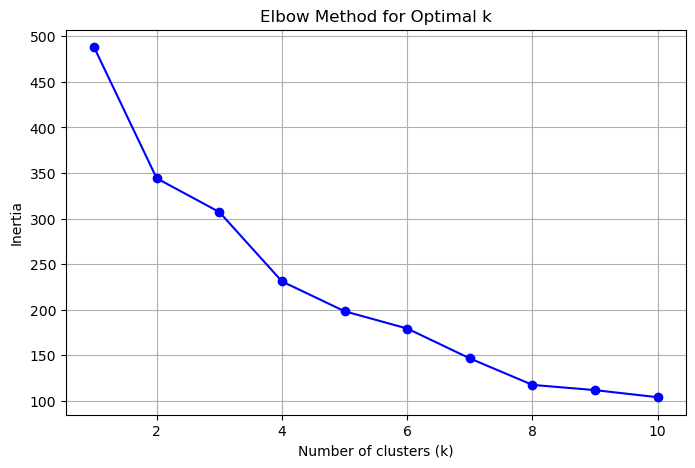

In [35]:
# use K-means to cluster vehicles based on their road usage patterns
from sklearn.cluster import KMeans

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vehicle_data[features])
    inertia.append(kmeans.inertia_)

# plot the elbow method
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [60]:
n_clusters = 4  # choose based on elbow method
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
vehicle_data['cluster'] = kmeans.fit_predict(vehicle_data[features])

In [61]:
vehicle_data

road,vehicle_id,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road__,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road__,cluster
0,1,16499.866,8972.230,975.180,0.00,0.754742,0.652501,0.696949,0.000000,1
1,2,26399.630,6710.260,1039.980,0.00,1.115323,1.060207,1.069699,0.000000,1
2,3,26903.090,7271.407,1399.777,0.00,1.163779,1.094111,1.093671,0.000000,1
3,4,133.670,6597.900,7846.860,0.00,0.613369,0.544172,0.506565,0.000000,0
4,5,24682.180,9247.150,1340.720,0.00,1.224829,1.083994,1.025529,0.000000,1
...,...,...,...,...,...,...,...,...,...,...
56,57,5618.110,8183.530,6711.880,0.00,0.839341,0.758790,0.698100,0.000000,0
57,58,9060.760,4286.970,3455.800,0.00,0.729847,0.673875,0.639581,0.000000,0
58,59,311.250,8658.370,8733.660,0.00,1.092477,0.834301,0.834301,0.000000,0
59,60,0.000,0.000,0.000,16792.62,0.000000,0.000000,0.000000,0.361143,3


In [38]:
clusters = vehicle_data.groupby('cluster')[features].mean()

In [39]:
clusters

road,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road__,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road__
cluster,,,,,,,,
0,-0.710975,0.070454,0.541910,-0.179634,-0.476045,-0.610886,-0.630591,-0.283530
1,0.399777,-0.258058,-0.351981,-0.013001,0.274442,0.446946,0.447551,0.140176
2,1.445720,0.468498,-0.796569,-0.164988,1.207898,1.325338,1.375337,0.525450
3,-1.123480,-1.637455,-1.251991,7.298926,-3.286479,-3.865707,-3.786669,0.447869


In [55]:
# rescale back the cluster centers to original scale
clusters_rescaled = pd.DataFrame(scaler.inverse_transform(clusters), columns=features)
clusters_rescaled

,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road__,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road__
0,3705.64500,6300.754233,6813.85800,0.890333,0.697913,0.643384,0.625081,0.071721
1,13683.84715,5088.820600,3418.55215,375.035000,0.884281,0.852487,0.838613,0.239386
2,23079.84830,7769.201100,1729.85130,33.777000,1.116086,1.026120,1.022367,0.391843
3,0.00000,0.000000,0.00000,16792.620000,0.000000,0.000000,0.000000,0.361143


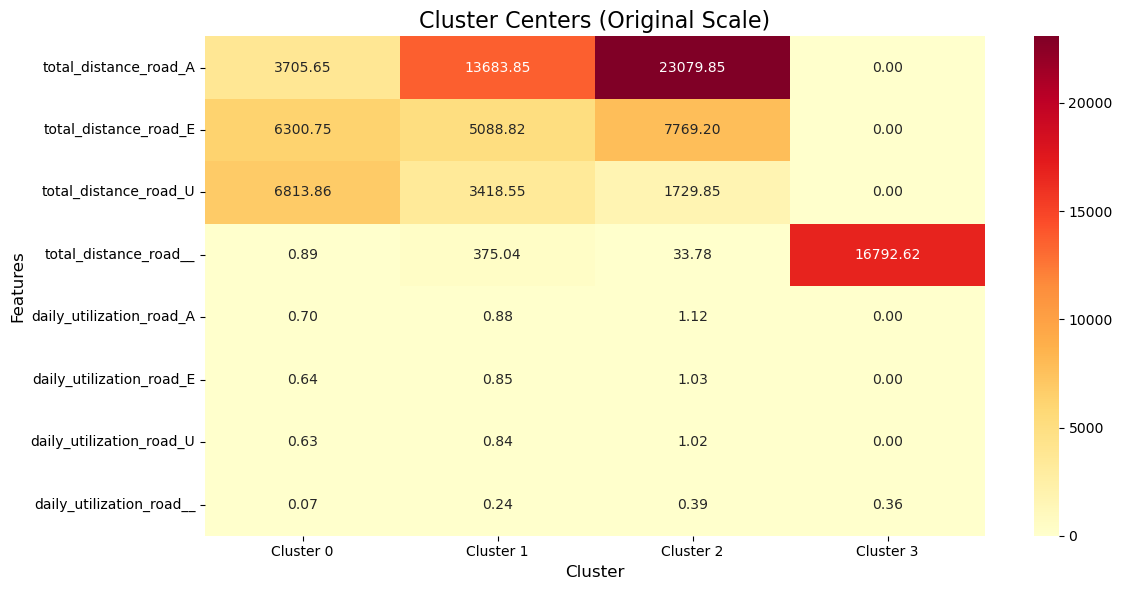

In [56]:
plt.figure(figsize=(12, 6))
sns.heatmap(clusters_rescaled.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            xticklabels=[f'Cluster {i}' for i in range(n_clusters)],
            yticklabels=features)
plt.title('Cluster Centers (Original Scale)', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

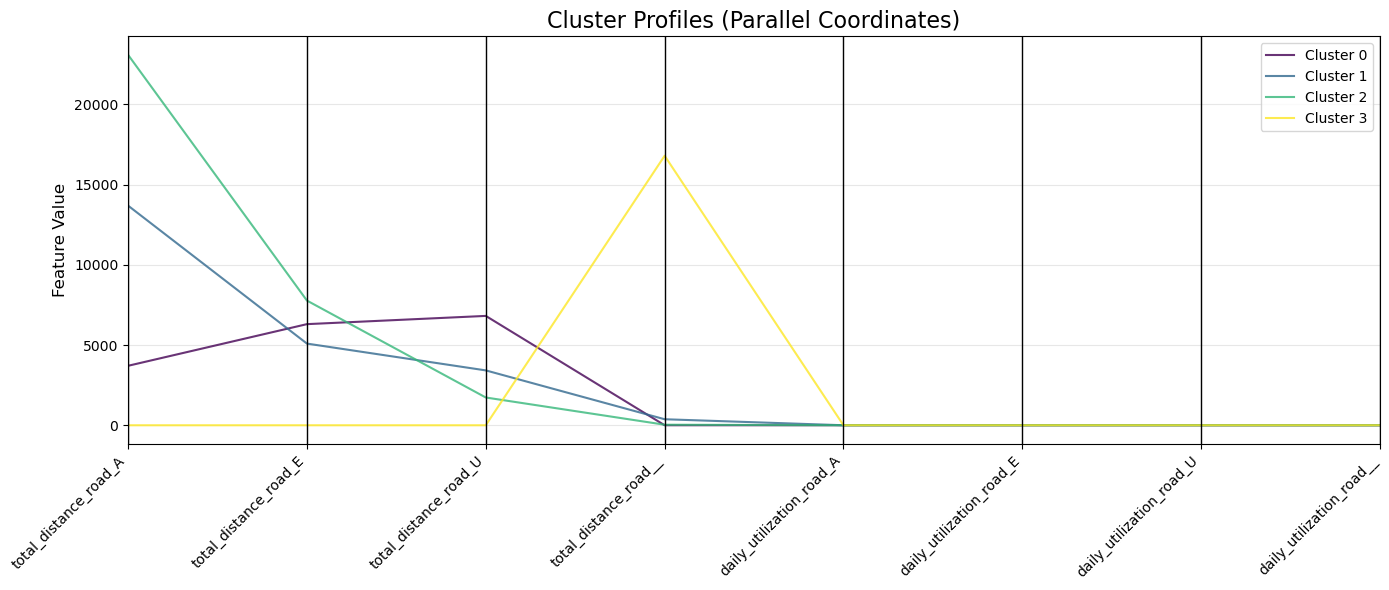

In [58]:
from pandas.plotting import parallel_coordinates

# Prepare data for parallel coordinates
cluster_viz = clusters_rescaled.copy()
cluster_viz['cluster'] = [f'Cluster {i}' for i in range(n_clusters)]

plt.figure(figsize=(14, 6))
parallel_coordinates(cluster_viz, 'cluster', colormap='viridis', alpha=0.8)
plt.title('Cluster Profiles (Parallel Coordinates)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Feature Value', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

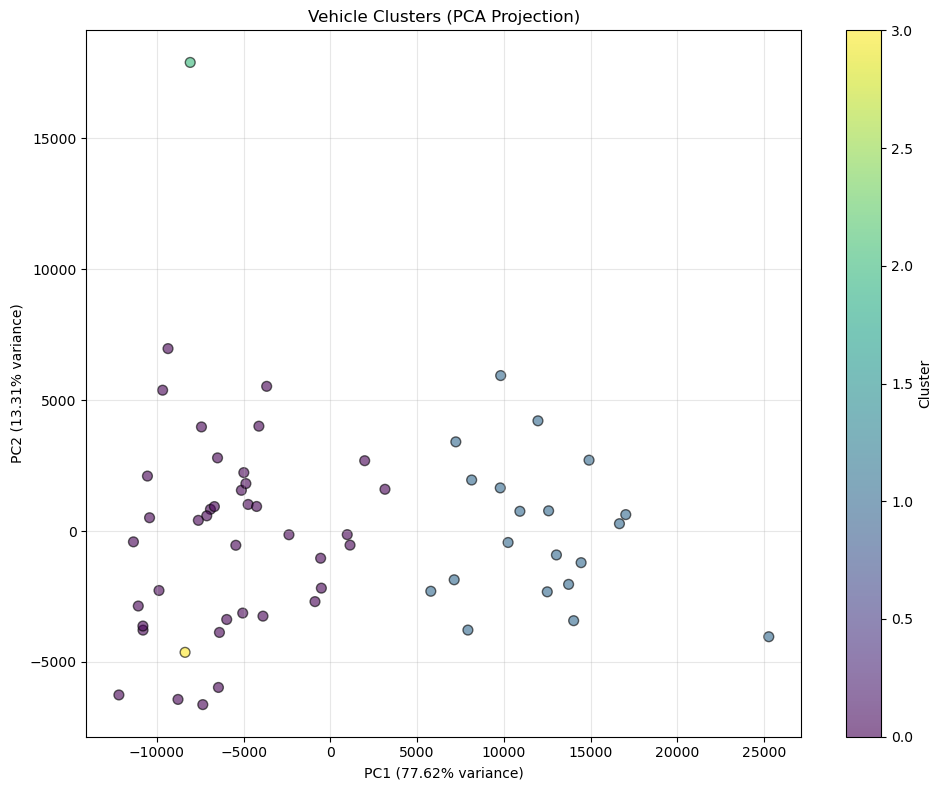

Total variance explained: 90.93%


In [62]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
vehicle_data_pca = pca.fit_transform(vehicle_data[features])

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(vehicle_data_pca[:, 0], vehicle_data_pca[:, 1], 
                     c=vehicle_data['cluster'], cmap='viridis', 
                     s=50, alpha=0.6, edgecolors='k')
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Vehicle Clusters (PCA Projection)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")


**2.** Choose at least three EV model from the EV database. Choose and define the evaluation metrics that you want to monitor. The mandatory one is the percentage of feasible trips.

In [ ]:
cars = {
    "Fiat 500e Hatchback 42 kWh": {
        "Useable Capacity": "37.3.0 kWh",
        "AC": {
            "Charge Power": "11 kW AC",
            "Charge Time (0->235 km)": "4h",
            "Charge Speed": "59 km/h"
        },
        "DC": {
            "Charge Power (max)": "85 kW DC",
            "Charge Power (10-80%)": "67 kW DC",
            "Charge Time (23->188 km)": "25 min",
            "Charge Speed": "390 km/h"
        },
        "Real_energy_consumption": {
            "City - Mild Weather": "105 Wh/km",
            "Highway - Mild Weather": "173 Wh/km",
            "Combined - Mild Weather": "138 Wh/km"
        }
    },
    "BYD SEAL 82.5 kWh RWD Design": {
        "Useable Capacity": "82.5 kWh",
        "AC": {
            "Charge Power": "11 kW AC",
            "Charge Time (0->480 km)": "9h",
            "Charge Speed": "54 km/h"
        },
        "DC": {
            "Charge Power (max)": "150 kW DC",
            "Charge Power (10-80%)": "100 kW DC",
            "Charge Time (48->384 km)": "36 min",
            "Charge Speed": "560 km/h"
        },
        "Real_energy_consumption": {
            "City - Mild Weather": "121 Wh/km",
            "Highway - Mild Weather": "181 Wh/km",
            "Combined - Mild Weather": "149 Wh/km"
        }
    },
    "Lotus Eletre S": {
        "Useable Capacity": "109.0 kWh",
        "AC": {
            "Charge Power": "22 kW AC",
            "Charge Time (0->480 km)": "6 hours",
            "Charge Speed": "82 km/h"
        },
        "DC": {
            "Charge Power (max)": "367 kW DC",
            "Charge Power (10-80%)": "259 kW DC",
            "Charge Time (48->384 km)": "19 min",
            "Charge Speed": "1060 km/h"
        },
        "Real_energy_consumption": {
            "City - Mild Weather": "156 Wh/km",
            "Highway - Mild Weather": "242 Wh/km",
            "Combined - Mild Weather": "196 Wh/km"
        }
    },
    "Audi e-tron GT RS": {
        "Useable Capacity": "85.0 kWh",
        "AC": {
            "Charge Power": "11 kW AC",
            "Charge Time (0->405 km)": "9h15m",
            "Charge Speed": "45 km/h"
        },
        "DC": {
            "Charge Power (max)": "268 kW DC",
            "Charge Power (10-80%)": "216 kW DC",
            "Charge Time (40->324 km)": "17 min",
            "Charge Speed": "1000 km/h"
        },
        "Real_energy_consumption": {
            "City - Mild Weather": "150 Wh/km",
            "Highway - Mild Weather": "227 Wh/km",
            "Combined - Mild Weather": "185 Wh/km"
        }
    }       
}

# Track More Performance Metrics
performance_metrics_to_track = {
    "Unfeasible_trips": {
        "total": 0,  # Total number of unfeasible trips
        "percentage": 0.0  # Percentage of unfeasible trips
    },
    "Battery_average_SoC": {
        "total": 0.0,  # Total state of charge (SoC) in percentage
        "percentage": 0.0  # Percentage value of average SoC
    }
}


**3.** Implement the replicator of trips and simulator of EV. Report it with diagram and/or pseudocode.

Pseudocode for Vehicle Battery Simulation

Data Preprocessing:

1. Load the dataset.
2. Sort the data by `vehicle_id` and `start_time`.

Initialization:

1. Define parameters:
    - Battery capacity
    - Energy consumption
    - Charging power
2. Create placeholders for:
    - Trip outcomes
    - Battery State of Charge (SoC)
    - Metrics

Simulation:

For each `vehicle_id`:
1. Initialize the full battery SoC.
2. For each trip:
    1. Calculate energy required for the trip.
    2. Check if SoC is sufficient:
        - If sufficient: Deduct energy and record the trip as feasible.
        - If insufficient: Record the trip as unfeasible.
3. Calculate parking duration before the next trip:
    - If parking time >= minimum charging time:
        - Recharge the battery based on charging power and parking duration.

Metrics Calculation:

1. Count unfeasible trips.
2. Calculate the average SoC across all trips.
3. Compare fast vs slow charging scenarios.

Visualization:

1. Generate diagrams showing:
    - SoC changes over trips.
    - Unfeasible trip counts.
    - Charging time distributions.
